In [1]:
import time
from threading import Thread

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from tqdm.auto import trange

from ensae_3a_gadmm.gadmm import display_df_log, gadmm_head_method, gadmm_tail_method
from ensae_3a_gadmm.logistic_regression import f

t = time.time()

## Importation of data

Le data provient du repo suivant : https://github.com/chentianyi1991/LAG-code s

In [2]:
data = np.loadtxt("data/data2/data.txt")
data.shape

(351, 34)

In [3]:
y = np.loadtxt("data/data2/y.txt", dtype=int)
y.shape

(351,)

In [4]:
# StandardScaler : mean of 0 and std of 1
scaled_data = StandardScaler().fit_transform(data)

pca = PCA(2)
pca_data = pca.fit_transform(scaled_data)
pca_data.shape

(351, 2)

In [5]:
pca_df = pd.DataFrame(data=pca_data, columns=["PC1", "PC2"])
pca_df["y"] = y
pca_df

,PC1,PC2,y
0,-1.668242,-2.054597,0
1,0.823940,-2.583636,1
2,-2.034095,-0.748245,0
3,1.252374,1.363326,1
4,0.017756,-1.845357,0
...,...,...,...
346,-3.156856,-0.000433,0
347,-3.562330,0.324750,0
348,-3.512043,0.204754,0
349,-3.308935,-0.343454,0


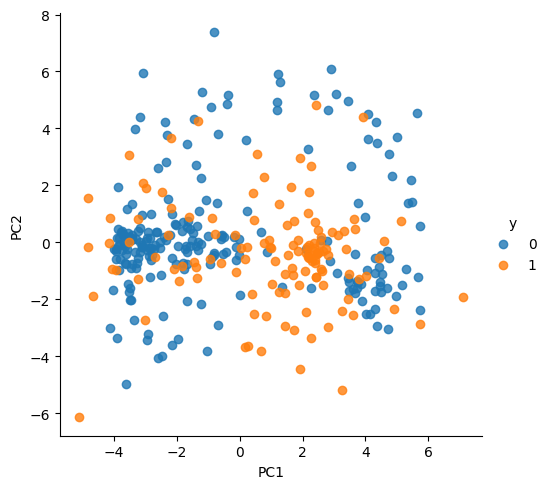

In [6]:
sns.lmplot(x="PC1", y="PC2", data=pca_df, hue="y", fit_reg=False, legend=True)

In [7]:
# Adding an intercept
temp_data = np.ones((data.shape[0], data.shape[1] + 1))
temp_data[:, 1:] = scaled_data
data = temp_data
data.shape

(351, 35)

In [8]:
d = data.shape[1]
d

35

## Logistic Regression

In [9]:
rho = 1

In [10]:
clf = LogisticRegression(
    penalty="l2", C=rho, fit_intercept=False, solver="liblinear"
).fit(data, y)
y_pred = clf.predict(data)
y_pred_proba = clf.predict_proba(data)
clf.score(data, y)  # compute accuracy

0.9259259259259259

In [11]:
opt_theta = clf.coef_
opt_theta

array([[-0.16162871, -2.25989579,  0.        , -0.8004997 ,  0.00761144,
        -0.99946311, -0.9730252 , -0.54479263, -1.07079607, -0.66992926,
        -0.19357204,  0.61352733,  0.18207117,  0.0964342 , -0.3013256 ,
        -0.67571157,  0.42383201, -0.09854566, -0.56972128,  0.80706223,
        -0.01100896, -0.09950051,  1.3649529 , -0.80355806, -0.40487275,
        -0.68251785, -0.18623943,  1.39654551,  0.07158301, -0.53248591,
        -0.93991849, -0.53082438,  0.17228759,  0.37834172,  0.86564326]])

In [12]:
loss = log_loss(y, y_pred_proba, labels=[0, 1])
loss

0.18694318521111666

## GADMM not parallelized

In [13]:
K = 1000  # number of iterations
M = 4  # number of workers
rho = 1

split_data = np.array_split(data, M)

In [14]:
len(split_data)

4

In [15]:
split_data[0].shape

(88, 35)

In [16]:
split_y = np.array_split(y, M)

In [17]:
len(split_y)

4

In [18]:
split_y[0].shape

(88,)

In [19]:
f(opt_theta, data, y)

0.18694318521111672

On a la même loss qu'avec sklearn, tout va bien !

---



In [20]:
# Initialisation
Theta = np.zeros((M, d))
Lamb = np.zeros((M, d))

# Iterative procedure
df_log = []

t1 = time.time()
for k in trange(K):
    # Step 1 : head workers
    for n in range(M):
        if n % 2 == 0:
            gadmm_head_method(
                sample_data=split_data[n],
                sample_y=split_y[n],
                lamb=Lamb,
                theta=Theta,
                m=M,
                n=n,
                rho=rho,
            )

    # Step 2 : tail workers
    for n in range(M):
        if n % 2 == 1:
            gadmm_tail_method(
                sample_data=split_data[n],
                sample_y=split_y[n],
                lamb=Lamb,
                theta=Theta,
                m=M,
                n=n,
                rho=rho,
            )

    # Step 3 : Update lambda
    for n in range(M - 1):
        Lamb[n] = Lamb[n] + rho * (Theta[n] - Theta[n + 1])

    for n in range(M):
        df_log.append(
            {
                "iteration": k,
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )

df_log = pd.DataFrame(df_log)

print(f"Temps : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t1))}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Temps : 00:03:37


In [21]:
Theta[0]

array([ 8.97247388e-01, -5.10586337e+00, -1.48804273e-05, -9.17581421e-01,
        3.47769607e-01, -1.81002400e+00, -1.56723330e+00, -4.81864488e-01,
       -1.78199053e+00, -1.37569508e+00, -2.53737511e-01,  1.81661435e+00,
        5.27827391e-01,  2.29022425e-01, -1.84603803e-01, -1.75592769e+00,
        1.38509041e+00, -3.31388400e-01, -1.09974904e+00,  2.44896548e+00,
       -6.67204073e-02, -1.13132928e-01,  1.68837815e+00, -1.55436923e+00,
       -8.09116086e-01, -1.16268928e+00,  7.32705502e-02,  2.58681519e+00,
        4.78178922e-02, -1.15475496e+00, -1.94933557e+00, -7.97707582e-01,
        5.15043833e-03,  2.34375782e-01,  1.46952620e+00])

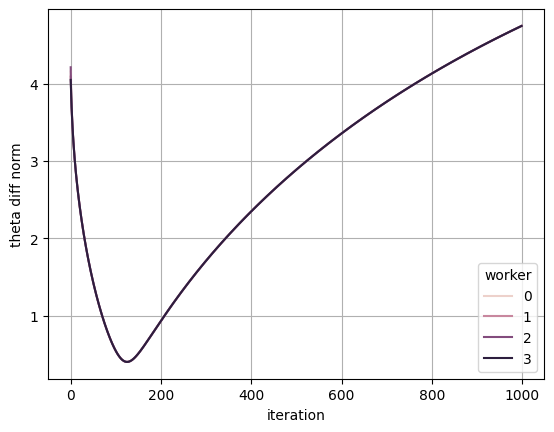

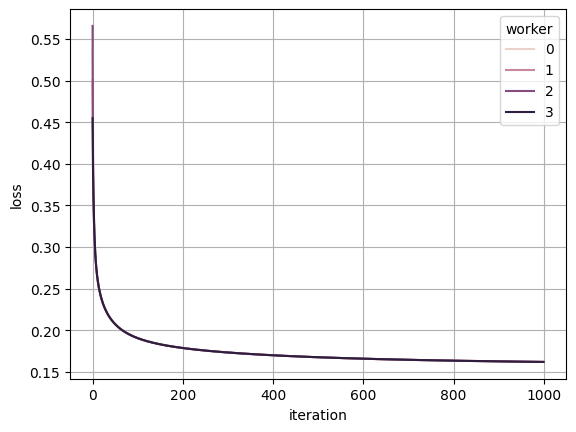

,worker,theta diff norm,loss
0,0,4.746865,0.161873
1,1,4.746866,0.161873
2,2,4.746868,0.161873
3,3,4.746867,0.161873


In [22]:
display_df_log(df_log, data, y, M, Theta, opt_theta)

## Multithreading

In [23]:
# Initialisation
Theta = np.zeros((M, d))
Lamb = np.zeros((M, d))

# Iterative procedure
df_log = []

t1 = time.time()
for k in trange(K):
    # Step 1 : head workers
    threads = []
    for n in range(M):
        if n % 2 == 0:
            thread = Thread(
                target=gadmm_head_method,
                args=(split_data[n], split_y[n], Lamb, Theta, M, n, rho),
            )
            threads.append(thread)
            thread.start()

    for thread in threads:
        thread.join()

    # Step 2 : tail workers
    threads = []
    for n in range(M):
        if n % 2 == 1:
            thread = Thread(
                target=gadmm_tail_method,
                args=(split_data[n], split_y[n], Lamb, Theta, M, n, rho),
            )
            threads.append(thread)
            thread.start()

    for thread in threads:
        thread.join()

    # Step 3 : Update lambda
    for n in range(M - 1):
        Lamb[n] = Lamb[n] + rho * (Theta[n] - Theta[n + 1])

    for n in range(M):
        df_log.append(
            {
                "iteration": k,
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )

df_log = pd.DataFrame(df_log)

print(f"Temps : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t1))}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Temps : 00:04:17


In [24]:
Theta[0]

array([ 8.97247388e-01, -5.10586337e+00, -1.48804273e-05, -9.17581421e-01,
        3.47769607e-01, -1.81002400e+00, -1.56723330e+00, -4.81864488e-01,
       -1.78199053e+00, -1.37569508e+00, -2.53737511e-01,  1.81661435e+00,
        5.27827391e-01,  2.29022425e-01, -1.84603803e-01, -1.75592769e+00,
        1.38509041e+00, -3.31388400e-01, -1.09974904e+00,  2.44896548e+00,
       -6.67204073e-02, -1.13132928e-01,  1.68837815e+00, -1.55436923e+00,
       -8.09116086e-01, -1.16268928e+00,  7.32705502e-02,  2.58681519e+00,
        4.78178922e-02, -1.15475496e+00, -1.94933557e+00, -7.97707582e-01,
        5.15043833e-03,  2.34375782e-01,  1.46952620e+00])

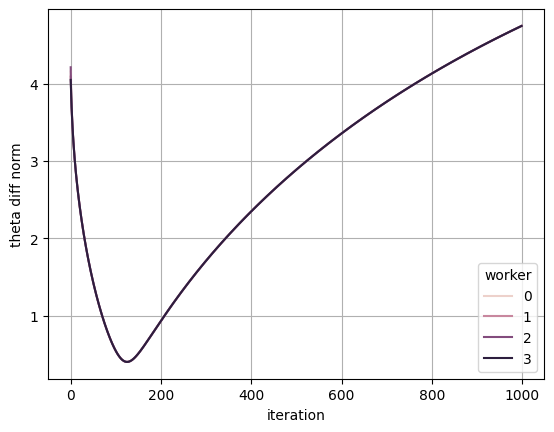

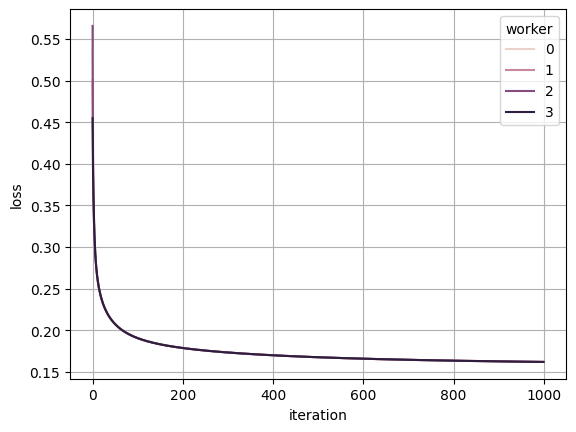

,worker,theta diff norm,loss
0,0,4.746865,0.161873
1,1,4.746866,0.161873
2,2,4.746868,0.161873
3,3,4.746867,0.161873


In [25]:
display_df_log(df_log, data, y, M, Theta, opt_theta)

In [26]:
print(
    f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}"
)

Temps d'exécution total : 00:07:56
